# ELEC 474 Machine Vision Project 

### import all needed libraries

In [1]:
import cv2 as cv
import numpy as np
import os
import operator
import copy
import random
import math
import time
import glob
from matplotlib import pyplot as plt

### load in folders

In [2]:
def LoadFolder(path, pic):
    return cv.imread(os.getcwd()+'//'+path+'//'+pic)

office_pic = 'office2'
StJames_pic = 'StJames'
WLH_pic = 'WLH'

### define global variabluees

In [3]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()
threshold_value = 200 
loweRatio = 0.7

### Step 1: Match Features

In [4]:
class Mapping:
    def __init__(self, kps, dps, matches):
        self.kps = kps
        self.dps = dps
        self.matches = matches
        self.pic1 = []
        self.pic2 = []
    def Loader(self, pic):
        self.pic1 = pic
    def Loader2(self, pic):
        self.pic2 = pic
    def __eq__(self, other) -> bool:
        return self.__dict__ == other.__dict__

In [5]:
def KpsAndDps(input,check,dps = my_SIFT_instance):
    gray = input
    if check == 1:
        gray = cv.cvtColor(input,cv.COLOR_BGR2GRAY)
    result = np.copy(gray)
    kps, dps = dps.detectAndCompute(gray,None)
    return (kps,dps)

In [6]:
def LoweRatioTest(temp1,temp2,query,train,number,ratio):
    flann = cv.FlannBasedMatcher(query,train)
    matches = flann.knnMatch(temp1,temp2,k = number)
    ratio_match = []
    for a,b in matches:
        if a.distance < ratio * b.distance:
            ratio_match.append([a])
    return ratio_match

In [7]:
def Matching(temp1, temp2, loweRatio):
    query = dict(algorithm = 0, trees = 5)
    train = dict(checks = 50)      
    matches = LoweRatioTest(temp1[1], temp2[1],query, train,number = 2, ratio = loweRatio)  
    return Mapping([temp1[0],temp2[0]], [temp1[1], temp2[1]], matches)

In [8]:
def MatchFeatures(path):
    index = 0
    new_list = []
    new_match = []
    points = []
    pic = OpenFile(path)
    for pic in pic:
        index += 1
        temp = LoadFolder(path, pic)
        new_list.append(temp)
        points.append(KpsAndDps(temp,check=1, dps = dps))
    seeds = 0
    pic_seeds = new_list[seeds]
    points_seeds = points[seeds]
    result = list(range(len(new_list)))
    result.remove(seeds)
    print("Matching the pictures")
    for a in result:
        temp = Matching(points_seeds, points[a], loweRatio)
        if len(temp.matches) > threshold_value:
            temp.Loader(pic_seeds)
            temp.Loader2(new_list[a])
            new_match.append(temp)
    return new_match

In [9]:
def OpenFile(path):
    ls = []
    dir = os.getcwd()+'//'+path
    files = os.listdir(dir)
    for filename in files:
        if os.path.splitext(filename)[1] == '.jpg':
            ls.append(filename)
    if ls.count != 0:
        print("Find the file!")
    return ls

In [10]:
def Plot(pic,dps):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    index = len(pic)
    for i in range(index):
        plt.subplot(1,index,i+1)
        if(len(pic[i].shape) == 2): 
            plt.imshow(pic[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(pic[i], cv.COLOR_BGR2RGB))
        plt.title(dps[i])
    plt.tight_layout()

In [11]:
dps = cv.xfeatures2d.SIFT_create()
b = MatchFeatures(office_pic)

Find the file!
Matching the pictures


### Step 2: Estimate Transformation 

In [30]:
def FindDirection(M: Mapping):
    left_half = []
    right_half = []
    for a in M:
        reference = a.pic1
        compare = a.pic2
        m1 = a.kps[0]
        m2 = a.kps[1]
        matches = a.matches
        p1 = np.float32([m1[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
        p2 = np.float32([m2[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
        pair, _ = cv.findHomography(p2, p1, method = cv.RANSAC) 
        invert_pair = np.linalg.inv(pair)
        result = np.dot(invert_pair,[0,0,1])
        if result[0] > 0: 
            left_half.append(compare)
        else:
            right_half.append(compare)
    return reference, left_half, right_half

In [31]:
def EstimateTransformation(pic1, pic2):
    temp1 = KpsAndDps(pic1,check=0)
    temp2 = KpsAndDps(pic2,check=0)
    match = Matching(temp1, temp2, loweRatio)
    m2 = temp2[0]
    m1 = temp1[0]
    matches = match.matches
    p2 = np.float32([m2[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
    p1 = np.float32([m1[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
    homo, select = cv.findHomography(p2, p1, cv.RANSAC, 4) 
    return homo

### Step 3: Merge Images

In [32]:
def Merge(seeds, left_half, right_half):
    output = seeds
    index = 0
    print("Start")
    a = left_half[0]
    for b in left_half[1:]:
        homo = EstimateTransformation(a,b)
        x_direction = np.linalg.inv(homo)
        point = np.dot(x_direction, np.array([a.shape[1], a.shape[0], 1]));
        p1 = np.dot(x_direction, np.array([0,0,1]))
        p1 = p1/p1[-1]
        x_direction[0][-1] += abs(p1[0])
        x_direction[1][-1] += abs(p1[1])     
        diff1 = abs(int(p1[1]))
        diff2 = abs(int(p1[0]))
        size = (int(point[0])+diff2, int(point[1])+diff1)
        val = cv.warpPerspective(a, x_direction, size)
        val[diff1:b.shape[0]+diff1, diff2:b.shape[1]+diff2] = b
        a = val
        index += 1 
    new_pic = DetectObject(a)
    index = 0
    temp = new_pic
    print("Please wait for around 30 mins to check the result")
    for each in right_half:
            homo = EstimateTransformation(temp,each)
            result = np.dot(homo, np.array([each.shape[1], each.shape[0], 1]))
            result = result / result[-1]
            p1 = np.dot(x_direction, np.array([0,0,1]))
            p1 = p1 / p1[-1]
            x_direction[0][-1] += abs(p1[0])
            x_direction[1][-1] += abs(p1[1])
            diff1 = abs(int(p1[1])) + int(result[0])
            diff2 = abs(int(p1[0])) + int(result[1])
            size = (temp.shape[1] + diff2, temp.shape[0] + diff1)
            val = cv.warpPerspective(each, homo, size)
            val = Wrap(temp, val)
            temp = DetectObject(val)
            index += 1    
    end_result = temp
    Plot([end_result],["Here is the final picture"])

In [33]:
def Wrap(pic, pic2):
    temp1, temp2 = pic.shape[:2]
    for a in range(0, temp2):
        for b in range(0, temp1):
            try:
                if(np.array_equal(pic[b,a],np.array([0,0,0])) and  np.array_equal(pic2[b,a],np.array([0,0,0]))):
                    pic2[b,a] = [0, 0, 0]
                else:
                    if(np.array_equal(pic2[b,a],[0,0,0])):
                        pic2[b,a] = pic[b,a]
                    else:
                        if not np.array_equal(pic[b,a], [0,0,0]):
                            blue,green,red = pic[b,a]
                            pic2[b,a] = [blue,green,red]
            except:
                pass
    return pic2

In [34]:
def DetectObject(pic):
    temp = pic 
    pic = cv.medianBlur(temp, 5)
    gray = cv.cvtColor(pic,cv.COLOR_BGR2GRAY)
    _, obj = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
    edge, _ = cv.findContours(obj, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    count = edge[0]
    a,b,c,d = cv.boundingRect(count)
    result = pic[b:b+d, a:a+c]
    Plot([result],"Detected pic"),
    return result

In [35]:
seed, a,c = FindDirection(b)                   

Start
Please wait for around 30 mins to check the result


<Figure size 1800x1200 with 0 Axes>

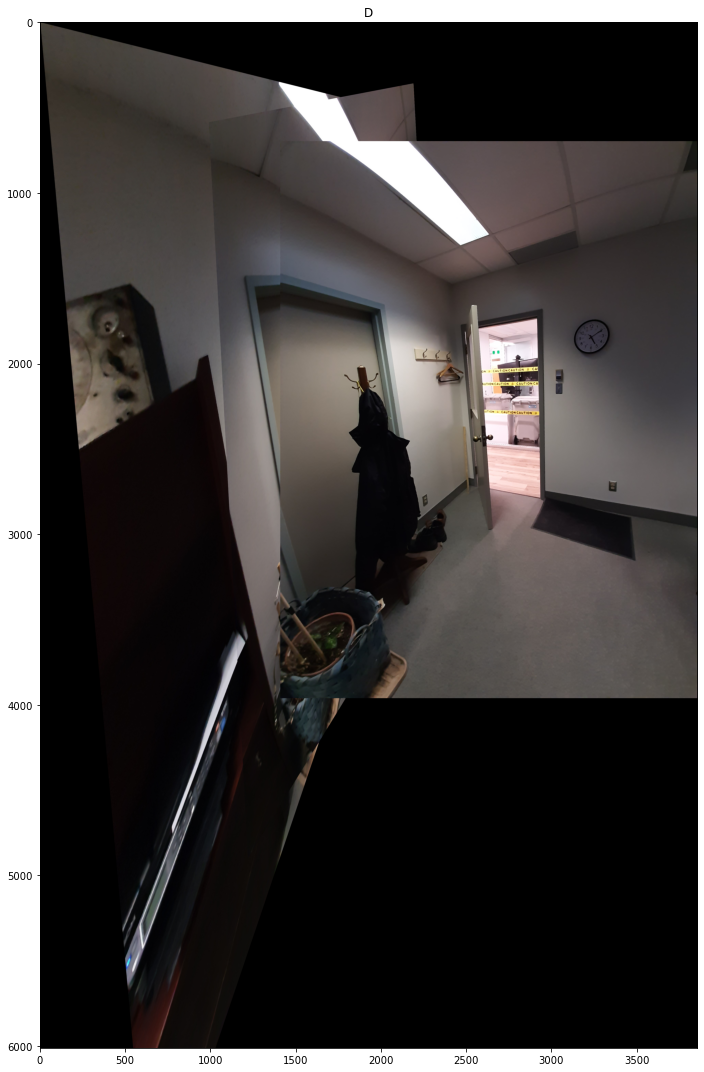

<Figure size 1800x1200 with 0 Axes>

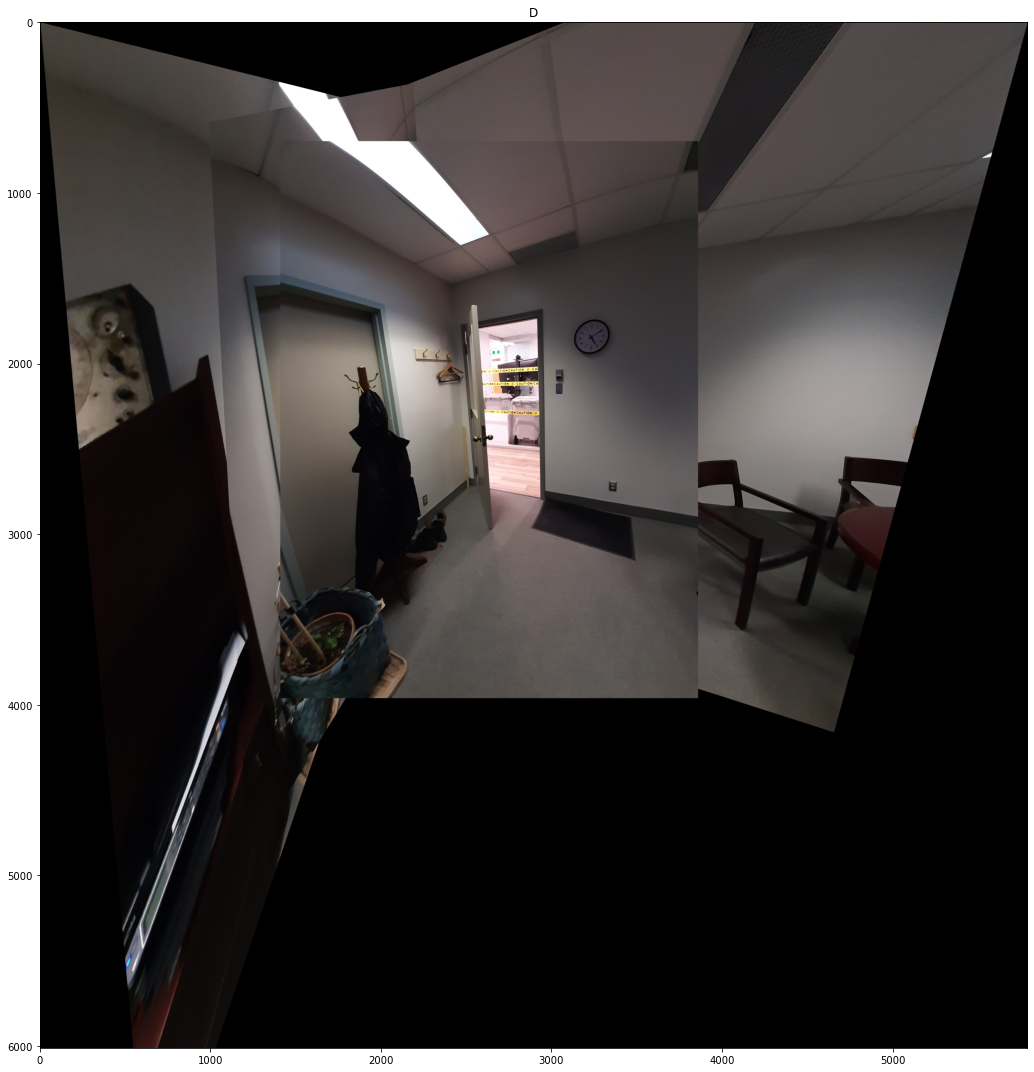

<Figure size 1800x1200 with 0 Axes>

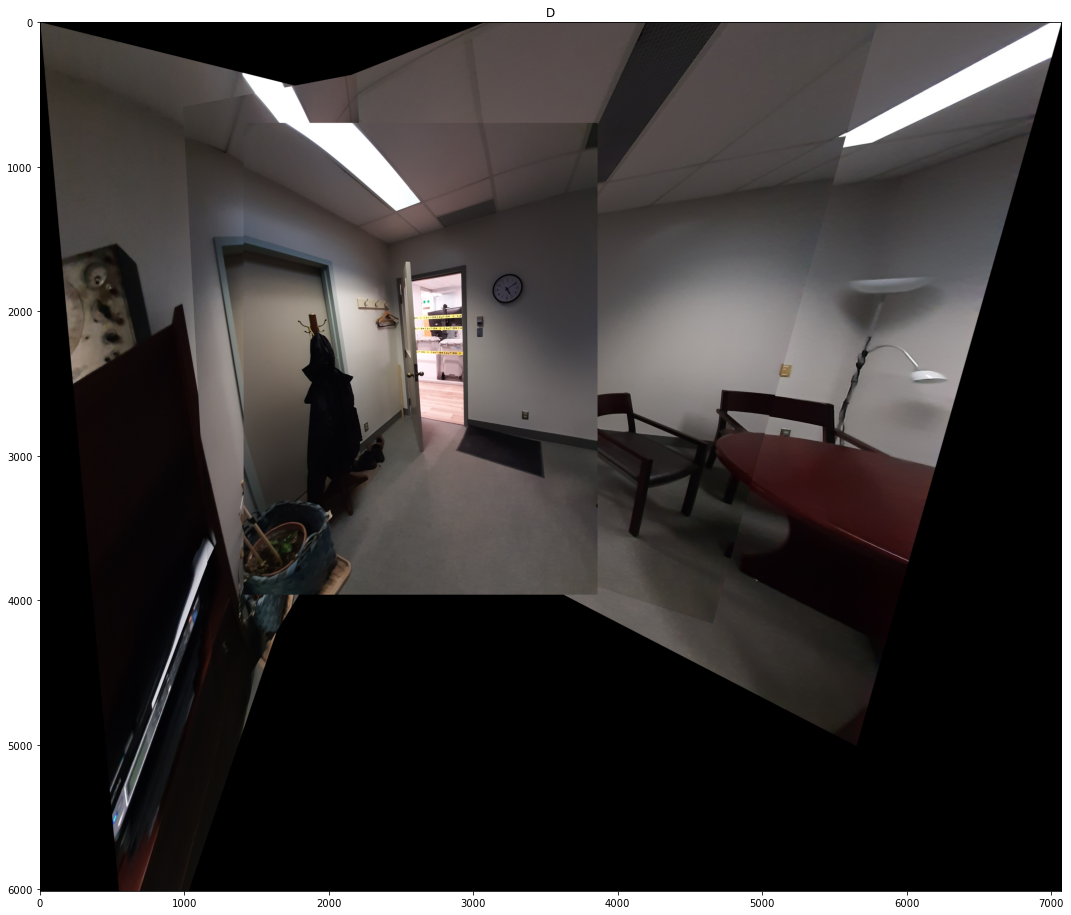

<Figure size 1800x1200 with 0 Axes>

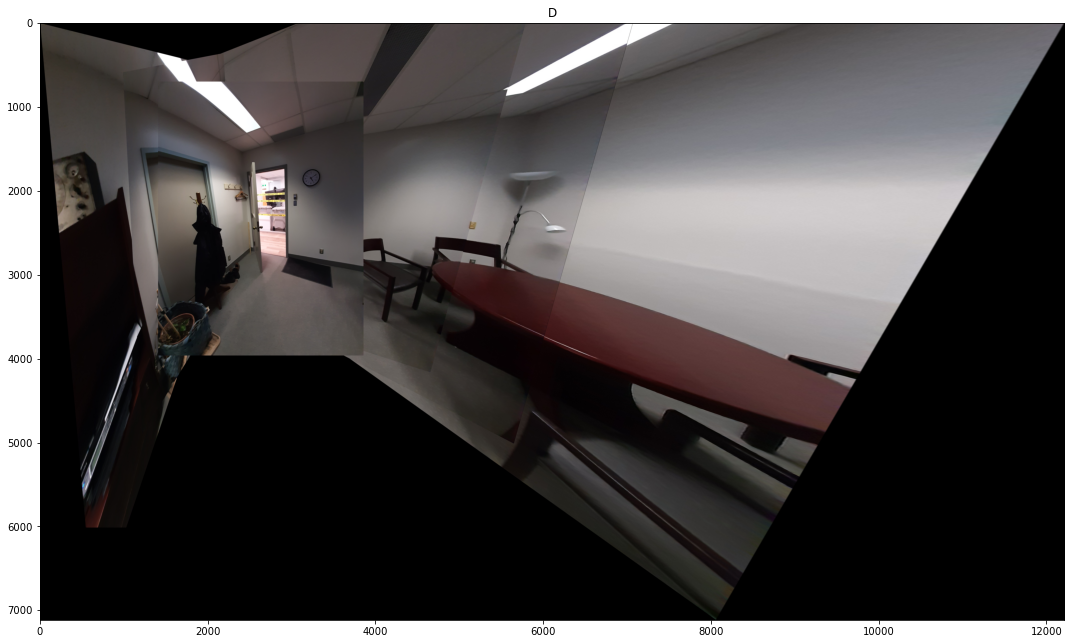

<Figure size 1800x1200 with 0 Axes>

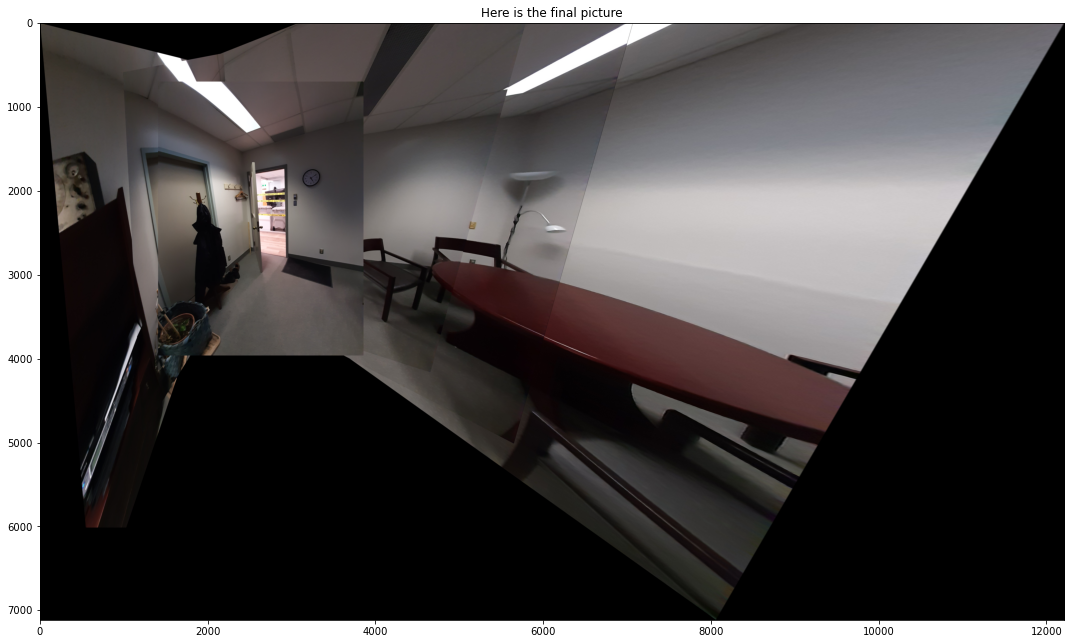

In [18]:
Merge(seed, a, c)